# Initializations

## Import libraries

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import io
import os
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import s3fs
import time
import pickle
from datetime import datetime
import scipy
print(scipy.__version__)
# from scipy.stats import median_absolute_deviation
from pycytominer import normalize, feature_select
 
pio.renderers.default = "png"  # Set to "svg" or "png" for static plots or "notebook_connected" for interactive plots
pd.set_option('display.width', 140)

1.11.4


In [3]:
# time.strftime(' %x%X')
# datetime.now().strftime('%X.%f')
# time.strftime('%X %x %Z')
print(datetime.now().strftime('%D-%X.%f'))
time_fmt = '%Y-%M-%d %H:%m:%S.%f'
time_fmt = '%Y-%M-%d %H:%m:%S.%f' 
print(datetime.now().strftime(time_fmt))

01/25/24-08:42:48.878463
2024-42-25 08:01:48.878925


In [4]:
gzip_compression_options = {"method": "gzip", 'compresslevel': 1,"mtime": 1}

metadata_path = "../cj-datasets/metadata"
plates = pd.read_csv(os.path.join(metadata_path,"plate.csv.gz"))
wells = pd.read_csv(os.path.join(metadata_path,"well.csv.gz"))
compound = pd.read_csv(os.path.join(metadata_path,"compound.csv.gz"))
orf = pd.read_csv(os.path.join(metadata_path,"orf.csv.gz"))


## gz, bz2, zip, tar, tar.gz, tar.bz2
# types = ['.gz', '.bz2','.zip', '.tar', '.tar.gz', '.tar.bz2']
type_bz2 = 'bz2'
type_gzip = 'gz'


In [5]:
input_path ="./metadata/"
output_path = "./output_11102023/"
prefix = '' ### Target-2' , 'MOA'
prefix_lc = prefix.lower().replace('-', '_')


CompoundExtendedMetadataFile        = f"{output_path}{prefix_lc}compound_extended_metadata.csv"

CompoundExtendedMetadata5SampleFile = f"{output_path}{prefix_lc}compound_extended_metadata_5samples.csv"
CompoundProfiles5SampleFileCSV      = f"{output_path}{prefix_lc}compound_profiles_5samples.csv"

CompoundExtendedMetadata2SampleFile = f"{output_path}{prefix_lc}compound_extended_metadata_2samples.csv"
CompoundProfiles2SampleFileCSV      = f"{output_path}{prefix_lc}compound_profiles_2samples.csv"

# CompoundProfiles2SampleFileParquet  = f"{output_path}{prefix_lc}compound_profiles_2samples.parquet"
# CompoundProfiles2SampleFileGZ       = f"{output_path}{prefix_lc}compound_profiles_2samples.gz"

CompoundExtendedMetadataSampleFile  = f"{output_path}{prefix_lc}compound_extended_metadata_samples.csv"
featureSelectionFile                = f"{output_path}{prefix_lc}_normalized_feature_select.csv.gz"

print(f" ")
print(f" Compound Extended MetadataFile              : {CompoundExtendedMetadataFile }")

print(f" Compound Extended Metadata 5 SampleFile     : {CompoundExtendedMetadata5SampleFile }")
print(f" Compound Profiles 5 Sample File CSV         : {CompoundProfiles5SampleFileCSV }")

print(f" ")
print(f" Compound Extended Metadata 2 SampleFile     : {CompoundExtendedMetadata2SampleFile }")
print(f" Compound Profiles 2 Samples File CSV        : {CompoundProfiles2SampleFileCSV}")
# print(f" ")
# print(f" CompoundProfiles2SamplesFile Parquet        : {CompoundProfiles2SampleFileParquet }")
# print(f" CompoundProfiles2SamplesFile gz             : {CompoundProfiles2SampleFileGZ }")
print(f" ")
print(f" featureSelectionFile                        : {featureSelectionFile}")


 
 Compound Extended MetadataFile              : ./output_11102023/compound_extended_metadata.csv
 Compound Extended Metadata 5 SampleFile     : ./output_11102023/compound_extended_metadata_5samples.csv
 Compound Profiles 5 Sample File CSV         : ./output_11102023/compound_profiles_5samples.csv
 
 Compound Extended Metadata 2 SampleFile     : ./output_11102023/compound_extended_metadata_2samples.csv
 Compound Profiles 2 Samples File CSV        : ./output_11102023/compound_profiles_2samples.csv
 
 featureSelectionFile                        : ./output_11102023/_normalized_feature_select.csv.gz


## Helper functions

In [6]:
profile_formatter = (
    "s3://cellpainting-gallery/cpg0016-jump/"
    "{Metadata_Source}/workspace/profiles/"
    "{Metadata_Batch}/{Metadata_Plate}/{Metadata_Plate}.parquet"
)

## images
loaddata_formatter = (
    "s3://cellpainting-gallery/cpg0016-jump/"
    "{Metadata_Source}/workspace/load_data_csv/"
    "{Metadata_Batch}/{Metadata_Plate}/load_data_with_illum.parquet"
)

# csv_formatter = (
#     "/mnt/i/cellpainting-gallery/cpg0016-jump/{Metadata_Plate}.csv")
#     # "{Metadata_Source}/workspace/profiles/"
#     # "{Metadata_Batch}/{Metadata_Plate}/{Metadata_Plate}.csv"

# local_formatter = (
#     "/mnt/i/cellpainting-gallery/cpg0016-jump/"
#     "{Metadata_Source}/workspace/profiles/"
#     "{Metadata_Batch}/{Metadata_Plate}/{Metadata_Plate}.parquet"
# )

csv_formatter = (
    "/mnt/i/cellpainting-gallery/cpg0016-jump/{2}.csv")
    # "{Metadata_Source}/workspace/profiles/"
    # "{Metadata_Batch}/{Metadata_Plate}/{Metadata_Plate}.csv"

local_formatter = (
    "/mnt/i/cellpainting-gallery/cpg0016-jump/"
    "{0}/workspace/profiles/"
    "{1}/{2}/{2}.parquet"
)

### Load Profile routines ( amazon S3 / local )

In [7]:
def read_profiles_from_s3(sample_set, s3_path):
    for i, row in sample_set.iterrows():
        # print(f'row : \n{row}')
        print(f"Metadata {i}  Source:{row['Metadata_Source']}  Batch:{row['Metadata_Batch']}   Plate:{row['Metadata_Plate']}   Plate Type:{row['Metadata_PlateType']}")
        s3_path = profile_formatter.format(**row.to_dict())
        print(f"Path: {s3_path}")
        dframes.append(
            pd.read_parquet(s3_path, storage_options={"anon": True}, columns=columns)
        )
        temp_dframes = pd.concat(dframes)
        stats = get_stats(stats, temp_dframes)
        # break
    dframes = pd.concat(dframes) 


def read_profiles_from_local(keys, source, columns):
    read_frames = []
    Metadata_Source, Metadata_Batch, Metadata_Plate = keys
    source_path = source.format(Metadata_Source, Metadata_Batch, Metadata_Plate)
    df = pd.read_parquet(source_path, columns=columns)
    
    # print(len(df.columns.to_list()))
    return df

In [8]:
# Get the bucket name and key of the parquet file
# bucket_name = 'my-bucket'
# key = 'my-file.parquet'

# Copy the file to a local location
# with open('my-file.parquet', 'wb') as f:
    # s3.download_file(bucket_name, key, f)

In [9]:
def cat_columns(column_list = None):
    from collections import defaultdict
    if isinstance(column_list, pd.DataFrame):
        print(f" input is dataframe shape: {column_list.shape}")
        column_list = column_list.columns.to_list()
    elif isinstance(column_list, list):
        print(f" input is list length {len(column_list)}")

    len(column_list)
    # col_list[:12]
    # keys = ["Cells_", "Cytoplasm_", "Nuclei_", "Metadata_", "Image_Granularity_", "Image_Intensity_", "Image_Texture_", "Image_Threshold_", "Image_ImageQuality_"]
    keys = ["Cells", "Cytoplasm", "Nuclei", "Metadata", "Image_Granularity", 
            "Image_Intensity", "Image_Texture", "Image_Threshold", "Image_ImageQuality", "Texture",
            "Channel", "Count", "ExecutionTime", "FileName", "Frame", "Granularity", "MD5Digest", "Width", "Height",
            "Series", "ModuleError", "PathName", "Scaling", "Threshold", "URL"]
    key_len = [len(x) for x in keys]
    ttls = defaultdict(int)  ## {'Cells': 0, 'Cytoplasm': 0 , 'Nuclei' : 0, 'Metadata': 0, 'Other': 0}
    cols = defaultdict(list)
    
    for i in column_list:
        for j  in range(len(keys)):
            if i[:key_len[j]] == keys[j]:
                # print(f" found   {j}  - {keys[j]}  {key_len[j]}    {i[:key_len[j]]}")
                ttls[keys[j]] += 1
                cols[keys[j]].append(i)
                break
        else:
            cols['Other'].append(i)
            ttls['Other']+= 1
            # print(f" not found :   {i}")
    
    for k,v in ttls.items():
        print(f" Field type: {k:20s}    count: {v}")   
    return cols

def get_cols_like(col_list, pattern = None):
    import re
    if not isinstance(pattern, list):
        pattern = [pattern]
    result = []
    for pat in pattern:
        p = re.compile(pat)    
        result += [ i for i in col_list if p.search(i) is not None]
    return result 

def disp_stats(df, cols):
    n_rows = df.shape[0]
    print(f"{' ':4s} {' ':60s}: {'min':>10s}   {'max':>10s}   {'std':>10s}   {'var':>10s}   {'mean':>10s}   {'median':>10s}    {'uniq rto':>10s}    {'freq rto':>10s}   {'quantile':^50s}")
    for ctr, i in enumerate(cols):
        print(f"{ctr:4d} {i[:60]:60s}: {df[i].min():10.2f}   {df[i].max():10.2f}   {df[i].std():10.2f}   {df[i].var():10.2f}"\
              f"   {df[i].mean():10.2f}   {df[i].median():10.2f}    {df[i].nunique()/n_rows:10.2f}    {calculate_frequency(df[i]):10.2f}     {np.quantile(df[i], [0.0,0.25, 0.50, 0.75,1.00] )}")

def check_values(df, cols):
    # if df is not None:
    #     print(f" dataframe shape: {df.shape}")
    #     cols = df.columns.to_list()
    # else:
    #     cols = column_list
    # len(col_list)    
    inv_columns = []
    n_rows = df.shape[0]
    print(f"\n Columns with invalid data from {len(cols)} columns " \
          f" {'min':>10s}    {'max':>10s}    {'std':>10s}    {'mean':>10s}    {'median':>10s}    {'quantile':^50s}")    
    for ctr, i in enumerate(cols):
        if (pd.isna(df[i].min()) or pd.isna(df[i].max()) or pd.isna(df[i].std()) 
           or df[i].max() == np.inf ): 
            inv_columns.append(i)
            print(f"{ctr:4d} {i[:45]:45s}: {df[i].min():10.2f}    {df[i].max():10.2f}    {df[i].std():10.2f}"\
                  f"    {df[i].mean():10.2f}    {df[i].median():10.2f}    {np.quantile(df[i], [0.0,0.25, 0.50, 0.75,1.00] )}")  
    if len(inv_columns) == 0:
        print(f" **** No Invalid Numeric Columns Found ****")
    return inv_columns

def reduce_col_sizes(df, cols):
    flt_cnt, int_cnt = 0, 0 
    for i in  cols:
        if df[i].dtype == 'float64':
            flt_cnt +=1
            df[i] = df[i].astype('float32')
            # print(f" {i} converted from float64 to {dframe[i].dtype}")
        elif df[i].dtype ==  np.dtype(object): 
            df[i] = df[i].astype(np.string_)
            print(f" {i} converted from object to np.string")
        elif df[i].dtype == 'int64':
            int_cnt += 1
            df[i] = df[i].astype('int32')
            print(f" {i} converted to int64 {dframe[i].dtype}")
    return df, flt_cnt, int_cnt

def calculate_frequency(feature_column):
    """Calculate frequency of second most common to most common feature.
    
    Parameters
    ----------
    feature_column : Pandas series of the specific feature in the population_df

    Returns
    -------
    Feature name if it passes threshold, "NA" otherwise
    """
    
    val_count = feature_column.value_counts()
    
    try:
        max_count = val_count.iloc[0]
    except IndexError:
        return np.nan
    
    try:
        second_max_count = val_count.iloc[1]
    except IndexError:
        return np.nan

    freq = second_max_count / max_count
    return freq

## Parquet files column metadata

# Loading JUMP Cell Painting Metadata 
<!-- This notebook loads a small number of plates with precomputed features and the metadata information. -->

- Order Extended Metadata Data set by Source, Batch, Plate

The following files contain the metadata information for the entire dataset.
The schema is [here](metadata/README.md).

## Build Profile Columns Metadata (if not existing)

Build dictionary of Parquet data columns - write columns to pickle

This list of column names will allow us to identify & control the columns we want to load from parquet files

In [25]:
# # keys = ('source_1', 'Batch1_20221004', 'UL001641')
# keys = ('source_6' , 'p210920CPU2OS48hw384exp028JUMP',   '110000296345') 

# dframe = read_profiles_from_local(keys, local_formatter,  columns = None)
# cols = dframe.columns.to_list()
# print(f" rows: {len(dframe)}  columns {len(cols)}")      
# cat_cols = cat_columns(dframe)

 rows: 384  columns 4765
 dataframe shape: (384, 4765)
 Field type: Metadata                count: 3
 Field type: Cells                   count: 1256
 Field type: Cytoplasm               count: 1241
 Field type: Image_Granularity       count: 80
 Field type: Image_ImageQuality      count: 107
 Field type: Image_Intensity         count: 110
 Field type: Image_Texture           count: 780
 Field type: Image_Threshold         count: 12
 Field type: Nuclei                  count: 1176


In [764]:
# tt = [] 
# for k in cols:
#     if (dframe[k].dtype in [np.int64]):
#         print(f" {k:50s}   {dframe[k].dtype}")
#         tt.append(k)
# len(tt)


In [768]:
# ParquetColumns = { 'Metadata' : {x: dframe[x].dtype for x in cat_cols['Metadata']},
#                    'Cells'    : {x: dframe[x].dtype for x in cat_cols['Cells']},
#                    'Cytoplasm': {x: dframe[x].dtype for x in cat_cols['Cytoplasm']},
#                     'Nuclei'  : {x: dframe[x].dtype for x in cat_cols['Nuclei']},
#                     'Image'   : {x: dframe[x].dtype for x in (cat_cols['Image_Granularity']+ cat_cols['Image_ImageQuality'] + 
#                                                               cat_cols['Image_Intensity']  + cat_cols['Image_Texture']      + 
#                                                               cat_cols['Image_Threshold'])},
#                  }

# print(len(floatConversion) + len(intConversion))
# import pickle
# with open("./metadata/parquet_columns.pkl", 'wb') as f: 
#     pickle.dump(ParquetColumns,f)

4762


In [14]:
# del ParquetColumns

# with open("./metadata/parquet_columns.pkl",'rb') as f:
#     ParquetColumns = pickle.load(f)

# for k,v in ParquetColumns.items():
#     print(f" {k:20s}   items: {len(v)}")

# for k,v in ParquetColumns['Cytoplasm'].items():
#     print(f" {k:50s}   type: {v}")


## Plates

**Plate Types:**

- **COMPOUND:** Plates of cells perturbed by chemical compounds.
- **DMSO:** Plates of cells perturbed by DMSO (compound negative control) in all the wells.
- **TARGET2:** Positive control plates, as described in https://github.com/jump-cellpainting/JUMP-Target.
- **COMPOUND_EMPTY:** Plates of untreated cells in all the wells.
- **ORF:** Plate of cells perturbed by ORFs.
- **TARGET1:** Plates of Target-1 compounds, as described in https://github.com/jump-cellpainting/JUMP-Target. -- DO NOT USE 
- **POSCON8:** Plate of cells perturbed by eight compound positive controls.

In [12]:
plates.info()
plates.head(100)
print("Unique source counts:", plates['Metadata_Source'].unique())
print("Unqiue batch counts :", len(plates['Metadata_Batch'].unique()))
print("Unqiue plate counts :", len(plates['Metadata_Plate'].unique()))
print("Unqiue platetype counts :", plates['Metadata_PlateType'].unique())
print("Number of batches   :", plates.Metadata_Batch.unique().shape[0])
plates.Metadata_PlateType.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2378 entries, 0 to 2377
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Metadata_Source     2378 non-null   object
 1   Metadata_Batch      2378 non-null   object
 2   Metadata_Plate      2378 non-null   object
 3   Metadata_PlateType  2378 non-null   object
dtypes: object(4)
memory usage: 74.4+ KB


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType
0,source_1,Batch1_20221004,UL000109,COMPOUND_EMPTY
1,source_1,Batch1_20221004,UL001641,COMPOUND
2,source_1,Batch1_20221004,UL001643,COMPOUND
3,source_1,Batch1_20221004,UL001645,COMPOUND
4,source_1,Batch1_20221004,UL001651,COMPOUND
...,...,...,...,...
95,source_10,2021_06_08_U2OS_48_hr_run4,Dest210608-152610,COMPOUND
96,source_10,2021_06_08_U2OS_48_hr_run4,Dest210608-152745,COMPOUND
97,source_10,2021_06_08_U2OS_48_hr_run4,Dest210608-152921,COMPOUND
98,source_10,2021_06_08_U2OS_48_hr_run4,Dest210608-153057,COMPOUND


Unique source counts: ['source_1' 'source_10' 'source_11' 'source_13' 'source_2' 'source_3'
 'source_4' 'source_5' 'source_6' 'source_7' 'source_8' 'source_9']
Unqiue batch counts : 143
Unqiue plate counts : 2378
Unqiue platetype counts : ['COMPOUND_EMPTY' 'COMPOUND' 'DMSO' 'TARGET2' 'CRISPR' 'ORF' 'TARGET1'
 'POSCON8']
Number of batches   : 143


Metadata_PlateType
COMPOUND          1729
ORF                251
CRISPR             148
TARGET2            141
DMSO                77
COMPOUND_EMPTY      20
POSCON8              8
TARGET1              4
Name: count, dtype: int64

## Wells

In [13]:
wells.info()
wells.head()
print("Unique source counts:", wells['Metadata_Source'].unique())
print("Unqiue well counts :", len(wells['Metadata_Well'].unique()))
print("Unqiue plate counts:", len(wells['Metadata_Plate'].unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096074 entries, 0 to 1096073
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Metadata_Source   1096074 non-null  object
 1   Metadata_Plate    1096074 non-null  object
 2   Metadata_Well     1096074 non-null  object
 3   Metadata_JCP2022  1096074 non-null  object
dtypes: object(4)
memory usage: 33.4+ MB


,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022
0,source_1,UL000081,A02,JCP2022_033924
1,source_1,UL000081,A03,JCP2022_085227
2,source_1,UL000081,A04,JCP2022_033924
3,source_1,UL000081,A05,JCP2022_047857
4,source_1,UL000081,A06,JCP2022_072229


Unique source counts: ['source_1' 'source_10' 'source_11' 'source_13' 'source_2' 'source_3'
 'source_4' 'source_5' 'source_6' 'source_7' 'source_8' 'source_9']
Unqiue well counts : 1536
Unqiue plate counts: 2378


## Compound

In [14]:
compound.info()
compound.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116753 entries, 0 to 116752
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Metadata_JCP2022   116753 non-null  object
 1   Metadata_InChIKey  116752 non-null  object
 2   Metadata_InChI     116752 non-null  object
dtypes: object(3)
memory usage: 2.7+ MB


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI
0,JCP2022_000001,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...
1,JCP2022_000002,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...
2,JCP2022_000003,AAALVYBICLMAMA-UHFFFAOYSA-N,InChI=1S/C20H15N3O2/c24-19-15-11-17(21-13-7-3-...
3,JCP2022_000004,AAANUZMCJQUYNX-UHFFFAOYSA-N,InChI=1S/C13H22N4O2S/c1-2-7-16-13(5-6-15-16)20...
4,JCP2022_000005,AAAQFGUYHFJNHI-UHFFFAOYSA-N,InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...


## ORF

**ORF Types:**

trt are ORF treatments, where the cells are perturbed by an ORF treatment.
- **poscon** are four compound treatments that are used as positive control.
- **negcon** are four ORF treatments that are used as negative control. They are not expected to cause morphological changes.

In [16]:
orf.info()
orf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15142 entries, 0 to 15141
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Metadata_JCP2022           15142 non-null  object 
 1   Metadata_broad_sample      15142 non-null  object 
 2   Metadata_Name              15132 non-null  object 
 3   Metadata_Vector            15142 non-null  object 
 4   Metadata_Transcript        15106 non-null  object 
 5   Metadata_Symbol            15107 non-null  object 
 6   Metadata_NCBI_Gene_ID      15107 non-null  object 
 7   Metadata_Taxon_ID          15107 non-null  object 
 8   Metadata_Gene_Description  14853 non-null  object 
 9   Metadata_Prot_Match        14320 non-null  float64
 10  Metadata_Insert_Length     15141 non-null  float64
 11  Metadata_pert_type         15142 non-null  object 
dtypes: float64(2), object(10)
memory usage: 1.4+ MB


,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,Metadata_Insert_Length,Metadata_pert_type
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,870.0,trt
1,JCP2022_900003,ccsbBroad304_00002,ORF005388.1_TRC304.1,pLX_304,NM_001088.3,AANAT,15,9606,aralkylamine N-acetyltransferase,100.0,621.0,trt
2,JCP2022_900004,ccsbBroad304_00003,ORF003876.1_TRC304.1,pLX_304,NM_000663.4,ABAT,18,9606,4-aminobutyrate aminotransferase,100.0,1500.0,trt
3,JCP2022_900005,ccsbBroad304_00007,ORF004679.1_TRC304.1,pLX_304,NM_000018.4,ACADVL,37,9606,acyl-CoA dehydrogenase very long chain,100.0,1965.0,trt
4,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,1584.0,trt


## Parquet Profile Columns Metadata 

Parquet files column metadata

In [ ]:
with open("./metadata/parquet_columns.pkl",'rb') as f:
    ParquetColumns = pickle.load(f)

for k,v in ParquetColumns.items():
    print(f" {k:20s}   items: {len(v)}")
# print(ParquetColumns['Cytoplasm'])

  ### Define different cell groups

In [27]:
cell_fld_grps = ['Cells_AreaShape', 'Cells_Children', 'Cells_Correlation', 
                 ## 'Cells_Correlation_Correlation', 'Cells_Correlation_K', 'Cells_Correlation_Manders','Cells_Correlation_Overlap', 'Cells_Correlation_RWC',
                 ## 'Cells_RadialDistribution_FracAtD', 'Cells_RadialDistribution_MeanFrac', 'Cells_RadialDistribution_RadialCV',
                 'Cells_Granularity', 'Cells_Intensity', 'Cells_Neighbors', 'Cells_Parent',
                 'Cells_RadialDistribution', 
                 'Cells_Texture', 
                 'Cells_Texture_AngularSecondMoment','Cells_Texture_Contrast', 'Cells_Texture_Correlation',
                 'Cells_Texture_DifferenceEntropy', 'Cells_Texture_DifferenceVariance', 'Cells_Texture_Entropy',
                 'Cells_Texture_InfoMeas1' , 'Cells_Texture_InfoMeas2' , 'Cells_Texture_InverseDifferenceMoment',
                 'Cells_Texture_SumAverage', 'Cells_Texture_SumEntropy', 'Cells_Texture_SumVariance',  'Cells_Texture_Variance']
for grp in cell_fld_grps:
    cellColumns = get_cols_like(numeric_columns,grp )
    print(f" {grp:40s}      {len(cellColumns)}")
print('\n')    
# cytoplasm_fld_names = [ x for x in ParquetColumns['Cytoplasm'].keys()]
# cytoplasm_fld_grps = set([x.split('_')[1] for x in cytoplasm_fld_names])
# cytoplasm_fld_grps = ['Cytoplasm_'+ x for x in cytoplasm_fld_grps]
# cytoplasm_fld_grps
cytoplasm_fld_grps = ['Cytoplasm_Texture',
                      'Cytoplasm_Number',
                      'Cytoplasm_Intensity',
                      'Cytoplasm_RadialDistribution',
                      'Cytoplasm_Granularity',
                      'Cytoplasm_Correlation',
                      'Cytoplasm_AreaShape']

for grp in cytoplasm_fld_grps:
    cellColumns = get_cols_like(numeric_columns,grp )
    print(f" {grp:40s}      {len(cellColumns)}")
print('\n')
# nuclei_fld_names = [ x for x in ParquetColumns['Nuclei'].keys()]
# nuclei_fld_grps = set([x.split('_')[1] for x in nuclei_fld_names])
# nuclei_fld_grps = ['Nuclei_'+ x for x in nuclei_fld_grps]
# nuclei_fld_grps
# ##nuclei_fld_names
nuclei_fld_grps = ['Nuclei_Location',
                   'Nuclei_Neighbors',
                   'Nuclei_ObjectSkeleton',
                   'Nuclei_Parent',
                   'Nuclei_Number',
                   'Nuclei_Intensity',
                   'Nuclei_Children',
                   'Nuclei_RadialDistribution',
                   'Nuclei_Granularity',
                   'Nuclei_Correlation',
                   'Nuclei_AreaShape',
                   'Nuclei_Texture']
 
for grp in nuclei_fld_grps:
    cellColumns = get_cols_like(numeric_columns,grp )
    print(f" {grp:40s}      {len(cellColumns)}")


 Cells_AreaShape                               53
 Cells_Children                                1
 Cells_Correlation                             80
 Cells_Granularity                             80
 Cells_Intensity                               75
 Cells_Neighbors                               14
 Cells_Parent                                  1
 Cells_RadialDistribution                      171
 Cells_Texture                                 780
 Cells_Texture_AngularSecondMoment             60
 Cells_Texture_Contrast                        60
 Cells_Texture_Correlation                     60
 Cells_Texture_DifferenceEntropy               60
 Cells_Texture_DifferenceVariance              60
 Cells_Texture_Entropy                         60
 Cells_Texture_InfoMeas1                       60
 Cells_Texture_InfoMeas2                       60
 Cells_Texture_InverseDifferenceMoment         60
 Cells_Texture_SumAverage                      60
 Cells_Texture_SumEntropy                      60


  ### Specify columns to read from extMetadata and parquet files

In [34]:
extMetadataColumns = ["Metadata_Source", "Metadata_Batch" ,"Metadata_Plate" , "Metadata_Well", "Metadata_JCP2022"]
extMetadataColumns = ["Metadata_Source", "Metadata_Batch" ,"Metadata_Plate" , "Metadata_Well", "Metadata_JCP2022", "TPSA"  , "lnTPSA"  , "log10TPSA", "permiation"]
extMetadataNames   = ["Metadata_Source", "Metadata_Batch" ,"Metadata_Plate" , "Metadata_Well", "Metadata_JCP2022", "Metadata_TPSA", "Metadata_lnTPSA", "Metadata_log10TPSA","permiation"]
categoricalColumns = ["Metadata_Source", "Metadata_Batch" ,"Metadata_Plate" , "Metadata_Well"]

print(' Ext Metadata Columns : ', extMetadataColumns)
print(' Categorical columns  : ', categoricalColumns) 
print(' Parquet Metadata Columns: ' ,ParquetColumns['Metadata'])

## all numeric columns 
numeric_columns  =  ParquetColumns['Cells'] | ParquetColumns['Cytoplasm'] | ParquetColumns['Nuclei']

print(f" all numeric columns: {len(numeric_columns)}")
 
## Remove numeric columns that contains bad values
for x in ['Cells_AreaShape_FormFactor', 'Cytoplasm_AreaShape_FormFactor', 'Nuclei_AreaShape_FormFactor']:
    del numeric_columns[x]
print(f" all numeric columns after removal of FormFactor Columns : {len(numeric_columns)}")

numeric_cols_list = [x for x in numeric_columns.keys()]

## Conversion dictionary for reading CSV files 
conversionDict = dict()
for k,v in numeric_columns.items():
    conversionDict[k] = np.float32

print(f" conversion dict length: {len(conversionDict)}")

conversionDict |= {x:'category'  for x in categoricalColumns}
print(f" conversion dict length (after addition of Categorical columns): {len(conversionDict)}")

## get_column list for fields to read from Parquet files 
get_columns = list(ParquetColumns['Metadata'] | numeric_columns)
print(f" all get_columns    : {len(get_columns)}")
# print(get_columns[:20])

## join Columns 
join_columns = extMetadataNames + list(numeric_columns)
print(f" all columns in join: {len(join_columns)}")
join_columns[:7]


print('\n\n')
print(f" Numeric columns :")
print(f"------------------")
_ = cat_columns(numeric_cols_list)

 Ext Metadata Columns :  ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'TPSA', 'lnTPSA', 'log10TPSA', 'permiation']
 Categorical columns  :  ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well']
 Parquet Metadata Columns:  {'Metadata_Source': dtype('O'), 'Metadata_Plate': dtype('O'), 'Metadata_Well': dtype('O')}
 all numeric columns: 3673
 all numeric columns after removal of FormFactor Columns : 3670
 conversion dict length: 3670
 conversion dict length (after addition of Categorical columns): 3674
 all get_columns    : 3673
 all columns in join: 3679


['Metadata_Source',
 'Metadata_Batch',
 'Metadata_Plate',
 'Metadata_Well',
 'Metadata_JCP2022',
 'Metadata_TPSA',
 'Metadata_lnTPSA']




 Numeric columns :
------------------
 input is list length 3670
 Field type: Cells                   count: 1255
 Field type: Cytoplasm               count: 1240
 Field type: Nuclei                  count: 1175


## Sample plates
Let's sample two plates of a certain type (encoded in `Metadata_PlateType`) from each data-generating center (`Metadata_Source`). Note that only 10 out of the 13 sources are currently available and `source_1` does not have the plate type being queried below.

In [28]:
sample = (
    plates.query('Metadata_PlateType=="COMPOUND"')
    .groupby("Metadata_Source")
    .sample(2, random_state=42)   ## sample 2 per Metadata_Source
)
sample
# sample.Metadata_Batch.sum()


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType
47,source_1,Batch6_20221102,UL000585,COMPOUND
44,source_1,Batch6_20221102,UL000579,COMPOUND
140,source_10,2021_06_22_U2OS_48_hr_run8,Dest210622-145122,COMPOUND
101,source_10,2021_06_14_U2OS_48_hr_run5,Dest210614-162933,COMPOUND
305,source_11,Batch1,EC000029,COMPOUND
316,source_11,Batch2,EC000044,COMPOUND
702,source_2,20210719_Batch_6,1086294024,COMPOUND
814,source_2,20210830_Batch_11,1086290477,COMPOUND
1071,source_3,CP_33_all_Phenix1,A13407bW,COMPOUND
875,source_3,CP60,BR5874c3,COMPOUND


`TARGET2` plates are "sentinel" plates that are run in each batch. More on all this in future updates.

## Extended Metadata 

In [35]:
# extMetadataColumns = ["Metadata_Source", "Metadata_Batch" ,"Metadata_Plate" , "Metadata_Well", "Metadata_JCP2022", "TPSA", "lnTPSA", "log10TPSA"]
# categoricalColumns = ["Metadata_Source", "Metadata_Batch" ,"Metadata_Plate" , "Metadata_Well"]

print(' Ext Metadata Columns : ', extMetadataColumns)
print(' Categorical columns  : ', categoricalColumns) 

CompoundExtendedMetadata2SampleFile

 Ext Metadata Columns :  ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'TPSA', 'lnTPSA', 'log10TPSA', 'permiation']
 Categorical columns  :  ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well']


'./output_11102023/compound_extended_metadata_2samples.csv'

In [47]:
ext_metadata = pd.read_csv(CompoundExtendedMetadata2SampleFile, 
                           usecols = extMetadataColumns,
                           header=0)
ext_metadata.sort_values(by=categoricalColumns, inplace=True, ignore_index=True )

In [48]:
ext_metadata.info()
ext_metadata.head(5)
ext_metadata.tail(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231028 entries, 0 to 231027
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Metadata_JCP2022  231028 non-null  object 
 1   Metadata_Source   231028 non-null  object 
 2   Metadata_Batch    231028 non-null  object 
 3   Metadata_Plate    231028 non-null  object 
 4   Metadata_Well     231028 non-null  object 
 5   TPSA              231028 non-null  float64
 6   lnTPSA            231028 non-null  float64
 7   log10TPSA         231028 non-null  float64
 8   permiation        231028 non-null  int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 15.9+ MB


,Metadata_JCP2022,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,TPSA,lnTPSA,log10TPSA,permiation
0,JCP2022_036592,source_1,Batch1_20221004,UL001641,A05,82.21,4.409277,1.914925,0
1,JCP2022_071885,source_1,Batch1_20221004,UL001641,A06,54.50,3.998201,1.736397,0
2,JCP2022_078645,source_1,Batch1_20221004,UL001641,A08,90.58,4.506233,1.957032,0
3,JCP2022_098761,source_1,Batch1_20221004,UL001641,A11,103.50,4.639572,2.014940,1
4,JCP2022_070236,source_1,Batch1_20221004,UL001641,A15,31.60,3.453157,1.499687,0


,Metadata_JCP2022,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,TPSA,lnTPSA,log10TPSA,permiation
231023,JCP2022_050165,source_9,20211103-Run16,GR00004421,Z08,58.56,4.070052,1.767601,0
231024,JCP2022_076910,source_9,20211103-Run16,GR00004421,Z09,127.09,4.844895,2.104111,1
231025,JCP2022_083151,source_9,20211103-Run16,GR00004421,Z12,120.49,4.791567,2.080951,1
231026,JCP2022_073861,source_9,20211103-Run16,GR00004421,Z18,95.44,4.558498,1.979730,0
231027,JCP2022_099794,source_9,20211103-Run16,GR00004421,Z19,99.28,4.597944,1.996862,0


In [49]:
# ext_metadata.reset_index(drop=True, inplace = True)
# print('---------------------------------------------------------------')
# print(' After Index Reset')
# print('---------------------------------------------------------------')
# ext_metadata.info()
# ext_metadata.head(5)
# ext_metadata.tail(5)

In [50]:
ext_metadata.memory_usage(deep=True) 

Index                    132
Metadata_JCP2022    16402988
Metadata_Source     15057995
Metadata_Batch      17234260
Metadata_Plate      15504410
Metadata_Well       13873113
TPSA                 1848224
lnTPSA               1848224
log10TPSA            1848224
permiation           1848224
dtype: int64

In [24]:
# del ext_metadata

## Read parquet profile file

In [51]:
keys = ('source_10','2021_06_07_U2OS_48_hr_run3','Dest210607-134443')
# keys = ('source_6' , 'p210920CPU2OS48hw384exp028JUMP',   '110000296345') 

group_data = ext_metadata.query('Metadata_Source == @keys[0] & Metadata_Batch == @keys[1] & Metadata_Plate == @keys[2]')
# group_data = ext_metadata.query('Metadata_Source == @keys[0] & Metadata_Batch == @keys[1]')

source_path = local_formatter.format(keys[0],keys[1],keys[2],)
print(source_path)

dframe = pd.read_parquet(source_path, columns=get_columns)

/mnt/i/cellpainting-gallery/cpg0016-jump/source_10/workspace/profiles/2021_06_07_U2OS_48_hr_run3/Dest210607-134443/Dest210607-134443.parquet


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/i/cellpainting-gallery/cpg0016-jump/source_10/workspace/profiles/2021_06_07_U2OS_48_hr_run3/Dest210607-134443/Dest210607-134443.parquet'

In [26]:
# dframe['Cytoplasm_RadialDistribution_MeanFrac_mito_tubeness_3of20']
# dframe.info(verbose = True) 
dframe.memory_usage(deep=True).sum()
dframe.memory_usage(deep=True)[:20]

11351168

Index                                     128
Metadata_Source                         25344
Metadata_Plate                          28416
Metadata_Well                           23040
Cells_AreaShape_Area                     3072
Cells_AreaShape_BoundingBoxArea          3072
Cells_AreaShape_BoundingBoxMaximum_X     3072
Cells_AreaShape_BoundingBoxMaximum_Y     3072
Cells_AreaShape_BoundingBoxMinimum_X     3072
Cells_AreaShape_BoundingBoxMinimum_Y     3072
Cells_AreaShape_Center_X                 3072
Cells_AreaShape_Center_Y                 3072
Cells_AreaShape_Compactness              3072
Cells_AreaShape_Eccentricity             3072
Cells_AreaShape_EquivalentDiameter       3072
Cells_AreaShape_EulerNumber              3072
Cells_AreaShape_Extent                   3072
Cells_AreaShape_MajorAxisLength          3072
Cells_AreaShape_MaxFeretDiameter         3072
Cells_AreaShape_MaximumRadius            3072
dtype: int64

In [798]:
# outputFile = open('./output_11102023/test_1.csv', mode = 'a')
# print(outputFile)

<_io.TextIOWrapper name='./output_11102023/test_1.csv' mode='a' encoding='UTF-8'>


In [799]:
# dframe.to_csv(outputFile, mode = 'a', index = False)
# outputFile.close()

In [ ]:
# dframe = pd.read_csv('./output_11102023/test_1.csv' )

# dframe.head(5)
# dframe.memory_usage(deep=True).sum()
# dframe.memory_usage(deep=True)[:20]
# dframe.info(verbose=True) 

In [ ]:
# dframe2 = pd.read_csv('./output_11102023/test_1.csv', dtype = conversionDict )

# dframe.head(5)
# dframe2.memory_usage(deep=True).sum()
# dframe2.memory_usage(deep=True)[:20]
# dframe2.info(verbose=True) 

###  Display Stats for columns

In [28]:
col_dict = cat_columns(dframe)

 dataframe shape: (384, 3673)
 Field type: Metadata                count: 3
 Field type: Cells                   count: 1255
 Field type: Cytoplasm               count: 1240
 Field type: Nuclei                  count: 1175


In [29]:
disp_stats(dframe, col_dict['Cells'][1200:])
# disp_stats(dframe, col_dict['Nuclei'][1000:])
# disp_stats(dframe, col_dict['Cytoplasm'][:200])

                                             :        min          max          std         mean       median                        quantile                     
   0 Cells_Texture_Variance_AGP_3_01_256     :       9.39        38.64         3.74        15.79        15.21   [ 9.3878  13.40375 15.2145  17.40425 38.64   ]
   1 Cells_Texture_Variance_AGP_3_02_256     :       9.40        38.57         3.71        15.77        15.20   [ 9.3969 13.4215 15.1965 17.3825 38.574 ]
   2 Cells_Texture_Variance_AGP_3_03_256     :       9.38        38.73         3.74        15.79        15.22   [ 9.3829  13.419   15.218   17.39375 38.727  ]
   3 Cells_Texture_Variance_AGP_5_00_256     :       9.33        38.85         3.74        15.68        15.11   [ 9.3296  13.29925 15.1085  17.3435  38.847  ]
   4 Cells_Texture_Variance_AGP_5_01_256     :       9.45        38.80         3.75        15.79        15.20   [ 9.451   13.36175 15.1995  17.406   38.796  ]
   5 Cells_Texture_Variance_AGP_5_02_256     : 

In [68]:
# cols_subset = get_cols_like(col_dict['Cells'], 'AreaShape')
# cols_subset = col_dict['Cells'][:100]

In [30]:
disp_stats(dframe, ['Cells_AreaShape_Area', 'Nuclei_Texture_Variance_RNA_10_03_256'])
# disp_stats(dframe, col_dict['Cells'][:200])
# disp_stats(dframe, integerColumns)

                                             :        min          max          std         mean       median                        quantile                     
   0 Cells_AreaShape_Area                    :    2401.90     63039.00      3114.51      3808.89      3550.55   [ 2401.9    3448.35   3550.55   3678.275 63039.   ]
   1 Nuclei_Texture_Variance_RNA_10_03_256   :      23.63       125.33         9.71        43.56        42.64   [ 23.633    37.65975  42.637    48.952   125.33   ]


###  Check for invalid columns 

In [31]:
inv_cols = check_values(dframe,  col_dict['Cells']+col_dict['Cytoplasm']+ col_dict['Nuclei'])
print(inv_cols)


 Columns with invalid data from 3670 columns 
                                                  :        min           max           std          mean        median                         quantile                     
[]


In [237]:
# check_values(dframe,col_dict['Cytoplasm'][:200])

# Reading profiles

## Load Extended metadata

The following files contain the metadata information for the entire dataset.
The schema is [here](metadata/README.md).

In [102]:
CompoundExtendedMetadata2SampleFile

'./output_11102023/compound_extended_metadata_2samples.csv'

In [111]:
ext_metadata = pd.read_csv(CompoundExtendedMetadata2SampleFile ,
                           usecols = [0,1,2,4,5,9,10,11], 
                           # usecols = extMetadataColumns, 
                           names=extMetadataNames,  
                           header=0,
                          )
ext_metadata.sort_values(by=categoricalColumns, inplace=True)

ext_metadata.info()
ext_metadata.head(3)
ext_metadata.tail(3)
ext_metadata.reset_index(drop=True, inplace = True)
# print('---------------------------------------------------------------')
# print(' After Index Reset')
# print('---------------------------------------------------------------')
# ext_metadata.info()
# ext_metadata.head(3)
# ext_metadata.tail(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231342 entries, 176094 to 146362
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Metadata_Source     231342 non-null  object 
 1   Metadata_Batch      231342 non-null  object 
 2   Metadata_Plate      231342 non-null  object 
 3   Metadata_Well       231342 non-null  object 
 4   Metadata_JCP2022    231342 non-null  object 
 5   Metadata_TPSA       231342 non-null  float64
 6   Metadata_lnTPSA     231342 non-null  float64
 7   Metadata_log10TPSA  231342 non-null  float64
dtypes: float64(3), object(5)
memory usage: 15.9+ MB


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA
176094,source_1,Batch1_20221004,UL001641,A07,JCP2022_088861,63.55,4.151827,1.803116
100932,source_1,Batch1_20221004,UL001641,A12,JCP2022_050926,59.06,4.078554,1.771293
100933,source_1,Batch1_20221004,UL001641,A12,JCP2022_050926,59.06,4.078554,1.771293


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA
149806,source_9,20211103-Run16,GR00004421,Z16,JCP2022_075595,69.97,4.248067,1.844912
149807,source_9,20211103-Run16,GR00004421,Z16,JCP2022_075595,69.97,4.248067,1.844912
146362,source_9,20211103-Run16,GR00004421,Z18,JCP2022_073861,95.44,4.558498,1.979730


In [105]:
ext_metadata.memory_usage(deep=True) 

Index                    128
Metadata_Source     15078430
Metadata_Batch      17257228
Metadata_Plate      15525892
Metadata_Well       13892096
Metadata_JCP2022    16425282
TPSA                 1850736
lnTPSA               1850736
log10TPSA            1850736
dtype: int64

## Group Ext Metadata

In [112]:
grouped_metadata = ext_metadata.groupby(by = ['Metadata_Source','Metadata_Batch','Metadata_Plate'])
len(grouped_metadata)
for ctr, (keys, group_data) in enumerate(grouped_metadata):
    print(f"{ctr:5d}     {keys}") 
    # group_data.info()
    # group_data.memory_usage(deep=True)
    if ctr > 3:
        break

1684

    0     ('source_1', 'Batch1_20221004', 'UL001641')
    1     ('source_1', 'Batch1_20221004', 'UL001643')
    2     ('source_1', 'Batch1_20221004', 'UL001645')
    3     ('source_1', 'Batch1_20221004', 'UL001651')
    4     ('source_1', 'Batch1_20221004', 'UL001653')


## Read profiles for loaded metadata

Now let's load the profiles from these plates.

Setting `columns = None` below will load all of the features.

```
profile_formatter = ("s3://cellpainting-gallery/cpg0016-jump/{Metadata_Source}/workspace/profiles/{Metadata_Batch}/{Metadata_Plate}/{Metadata_Plate}.parquet")
```

<div class="alert alert-warning">
WARNING: Files are located in S3. This loop loads only two features per each sampled plate; loading many feature and/or many plates can take several minutes.
</div>

### For each ExtMetadata group and read matching parquet profile (plate)

In [113]:
df_profiles_list = []
rows = 0
ttl_rows = 0

for i, (keys, group_data) in enumerate(grouped_metadata):
# for i in [1]:
    print(keys)
    dframe = read_profiles_from_local(keys, local_formatter, get_columns)
    print(len(dframe.columns.to_list()))
    df_join = pd.merge(group_data, dframe, how='left', on=['Metadata_Source', 'Metadata_Plate', 'Metadata_Well'])

    rows += len(df_join)
    ttl_rows += rows
    
    df_profiles_list.append(df_join)
    print(f"file ctr: {i} rows: {rows}  Total rows {ttl_rows}")
    break
    # if i == 10 :
        # break


df_profiles = pd.concat(df_profiles_list)
print(f" number of groups: {i}  total number of rows: {ttl_rows}")

('source_1', 'Batch1_20221004', 'UL001641')
3673
file ctr: 0 rows: 608  Total rows 608
 number of groups: 0  total number of rows: 608


In [109]:
df_profiles.head(4)
df_profiles['Metadata_Plate'].unique()

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,TPSA,lnTPSA,log10TPSA,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,source_1,Batch1_20221004,UL001641,A07,JCP2022_088861,63.55,4.151827,1.803116,3808.1,7228.8,...,87.377,89.595,84.613,83.577,84.613,83.847,83.570,85.001,83.487,84.289
1,source_1,Batch1_20221004,UL001641,A12,JCP2022_050926,59.06,4.078554,1.771293,3656.7,6883.0,...,77.073,79.241,75.460,74.542,75.545,74.663,74.535,74.743,74.412,75.154
2,source_1,Batch1_20221004,UL001641,A12,JCP2022_050926,59.06,4.078554,1.771293,3656.7,6883.0,...,77.073,79.241,75.460,74.542,75.545,74.663,74.535,74.743,74.412,75.154
3,source_1,Batch1_20221004,UL001641,A13,JCP2022_042105,72.92,4.289363,1.862847,4036.1,7580.4,...,84.880,87.777,83.932,82.470,83.330,82.790,82.393,82.479,81.841,82.713


array(['UL001641'], dtype=object)

In [114]:
df_join.head(4)
# df_profiles['Metadata_Plate'].unique()

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,source_1,Batch1_20221004,UL001641,A07,JCP2022_088861,63.55,4.151827,1.803116,3808.1,7228.8,...,87.377,89.595,84.613,83.577,84.613,83.847,83.570,85.001,83.487,84.289
1,source_1,Batch1_20221004,UL001641,A12,JCP2022_050926,59.06,4.078554,1.771293,3656.7,6883.0,...,77.073,79.241,75.460,74.542,75.545,74.663,74.535,74.743,74.412,75.154
2,source_1,Batch1_20221004,UL001641,A12,JCP2022_050926,59.06,4.078554,1.771293,3656.7,6883.0,...,77.073,79.241,75.460,74.542,75.545,74.663,74.535,74.743,74.412,75.154
3,source_1,Batch1_20221004,UL001641,A13,JCP2022_042105,72.92,4.289363,1.862847,4036.1,7580.4,...,84.880,87.777,83.932,82.470,83.330,82.790,82.393,82.479,81.841,82.713


In [82]:
len(df_profiles.columns.to_list())
col_dict = cat_columns(df_profiles)
# col_dict['Nuclei'][1000:]

3678

 input is dataframe shape: (608, 3678)
 Field type: Metadata                count: 5
 Field type: Other                   count: 3
 Field type: Cells                   count: 1255
 Field type: Cytoplasm               count: 1240
 Field type: Nuclei                  count: 1175


## Normalize by Plate|

**`normalize Parameters()`**

- **profiles :** pandas.core.frame.DataFrame or path\
    Either a pandas DataFrame or a file that stores profile data
- **features :** list\
    A list of strings corresponding to feature measurement column names in the `profiles` DataFrame. All features listed must be found in `profiles`.\
    Defaults to `"infer"`. If `"infer"`, then assume cell painting features are those prefixed with `"Cells"`, `"Nuclei"`, or `"Cytoplasm"`.
- **image_features:** bool, default False\
    Whether the profiles contain image features.
- **meta_features :** list\
    A list of strings corresponding to metadata column names in the `profiles`DataFrame. All features listed must be found in `profiles`. Defaults to "infer".
    If `"infer"`, then assume metadata features are those prefixed with `"Metadata"`
- **samples :** sr, default `all`r\
    The metadata column values to use as a normalization reference. We often us econtrol samples. The function uses a `pd.query()` function, so you should\
    structure samples in this fashion. An example is"Metadata_treatment == 'control'" (include all quotes). Defaults to "all".
- **method :** str  `'standardize'` | `'robustize'` | `'mad_robustize'` | `'spherize'` \
    How to normalize the dataframe. Defaults to "standardize". Check avail_method sfor available normalization methods.
- **output_file :** str, optional\
    If provided, will write normalized profiles to file. If not specified, will return the normalized profiles as outpu.t\
    We recommend that this output file b  suffixed with "_normalized.csv".
- **output_type :** str, optional\
    If provided, will write normalized profiles as a specified file type (either CSV or parquet).
    If not specified and output_file is provided, then the file will be outputed as CSV as default.
- **compression_options :** str or dict, optional\
    Contains compression options as input to pd.DataFrame.to_csv(compression=compression_options). pandas version >= 1.2.
- **float_format :** str, optional\
    Decimal precision to use in writing output file as input to
    pd.DataFrame.to_csv(float_format=float_format). For example, use "%.3g" for 3
    decimal precision.
- **mad_robustize_epsilon:** float, optional\
    The mad_robustize fudge factor parameter. The function only uses
    this variable if method = "mad_robustize". Set this to 0 if
    mad_robustize generates features with large values.
- **spherize_center :** bool\
    If the function should center data before sphering (aka whitening). The
    function only uses this variable if method = "spherize". Defaults to True.
- **spherize_method :** str\
    The sphering (aka whitening) normalization selection. The function only uses
    this variable if method = "spherize". Defaults to "ZCA-corr". See
    :py:func:`pycytominer.operations.transform` for available spherize methods.
- **spherize_epsilon :** float, default 1e-6.\
    The sphering (aka whitening) fudge factor parameter. The function only uses
    this variable if method = "spherize".
  
**Returns**
 
- **normalized :** pandas.core.frame.DataFrame, optional\
    The normalized profile DataFrame. If output_file=None, then return the
    DataFrame. If you specify output_file, then write to file and do not return
    data.
, then write to file and do not return
        data
.

In [115]:
try:
    df_normalized = normalize(
        profiles=df_joim,
        features="infer",
        meta_features="infer",
        samples="all",
        method="standardize",
        # method="robustize",
        # method="mad_robustize",
        # method="spherize",
        # output_file=None,
        # mad_robustize_epsilon = 0 , 
        # compression_options=compression_options,
    )    
except Exception as e:
    print(f" exception:  {e} occurred at {keys}")

In [117]:
df_normalized.head(5)

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,source_1,Batch1_20221004,UL001641,A07,JCP2022_088861,63.55,4.151827,1.803116,-0.090949,-0.089839,...,-0.063635,-0.090584,-0.080025,-0.068345,-0.069226,-0.063567,-0.072309,-0.047511,-0.064414,-0.061068
1,source_1,Batch1_20221004,UL001641,A12,JCP2022_050926,59.06,4.078554,1.771293,-0.104021,-0.109172,...,-0.264675,-0.299316,-0.272180,-0.263496,-0.258986,-0.256941,-0.263362,-0.257096,-0.255702,-0.251433
2,source_1,Batch1_20221004,UL001641,A12,JCP2022_050926,59.06,4.078554,1.771293,-0.104021,-0.109172,...,-0.264675,-0.299316,-0.272180,-0.263496,-0.258986,-0.256941,-0.263362,-0.257096,-0.255702,-0.251433
3,source_1,Batch1_20221004,UL001641,A13,JCP2022_042105,72.92,4.289363,1.862847,-0.071264,-0.070181,...,-0.112353,-0.127234,-0.094322,-0.092256,-0.096074,-0.085823,-0.097198,-0.099039,-0.099109,-0.093911
4,source_1,Batch1_20221004,UL001641,A13,JCP2022_042105,72.92,4.289363,1.862847,-0.071264,-0.070181,...,-0.112353,-0.127234,-0.094322,-0.092256,-0.096074,-0.085823,-0.097198,-0.099039,-0.099109,-0.093911


In [95]:
# df_normalized[:10]
# df_normalized.isna().any(axis=1)

In [664]:
# disp_stats(df_normalized, col_dict['Cells'][:20])

In [118]:
disp_stats(df_normalized, ['Cells_AreaShape_Area', 'Nuclei_Texture_Variance_RNA_10_03_256'])

                                             :        min          max          std         mean       median                        quantile                     
   0 Cells_AreaShape_Area                    :      -0.16        19.83         1.00         0.00        -0.07   [-0.15879352 -0.0842839  -0.07189441 -0.05749108 19.83427899]
   1 Nuclei_Texture_Variance_RNA_10_03_256   :      -0.92        15.52         1.00         0.00        -0.11   [-0.92242735 -0.25618447 -0.11426124  0.04399626 15.52449938]


## Display and plot normalized columns

In [90]:
# disp_stats(df_normalized_robust, ['Cells_AreaShape_Area', 'Nuclei_Texture_Variance_RNA_10_03_256'])
# disp_stats(df_normalized_mad, ['Cells_AreaShape_Area', 'Nuclei_Texture_Variance_RNA_10_03_256'])
# len(col_dict['Cells'])

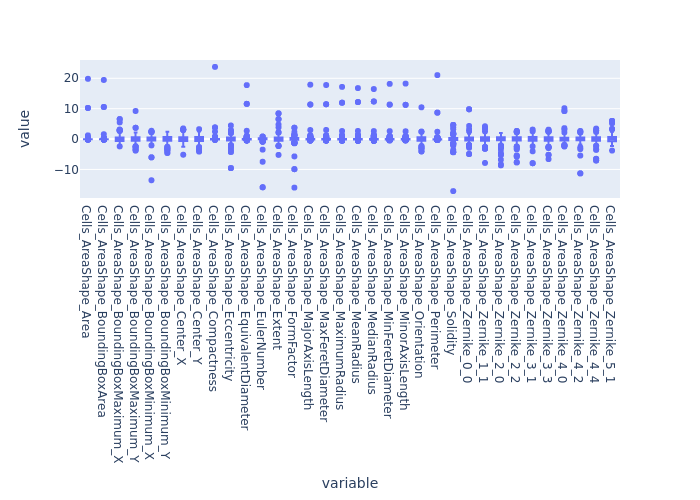

In [31]:
fig = px.box(df_normalized, y=cols_subset[:34], notched=True)
fig.show()

# Read Normalized Compound/Profiles table

In [139]:
profilesFile = CompoundProfiles2SampleFileCSV +'.'+ type_bz2
# oldOutputFile ='./output_11102023/compound_profiles_2samples_old2.csv.bz2'
# del df_profiles_list 
print(f" Read from {profilesFile}")
nrows = 5000

 Read from ./output_11102023/compound_profiles_2samples.csv.bz2


In [45]:
df_profiles =  pd.read_csv(profilesFile, 
                           nrows = 20000,
                           skiprows = 20000, 
                           header = 0, 
                           names = join_columns,
                           dtype = conversionDict,
                           usecols = ['Metadata_JCP2022','Cells_AreaShape_Area'])
df_profiles.columns
df_profiles.loc[0]
df_profiles.memory_usage(deep=True).sum()
df_profiles.memory_usage(deep=True)[:20]
df_profiles.head(5)
df_profiles.info(verbose=True)

Index(['Metadata_JCP2022', 'Cells_AreaShape_Area'], dtype='object')

Metadata_JCP2022              JCP2022_002416
Cells_AreaShape_Area    -0.10364100951446817
Name: 0, dtype: object

36797

Index                     128
Metadata_JCP2022        17752
Cells_AreaShape_Area    18917
dtype: int64

,Metadata_JCP2022,Cells_AreaShape_Area
0,JCP2022_002416,-0.10364100951446817
1,JCP2022_067802,0.2909296155289947
2,JCP2022_080082,0.28737492521328745
3,Metadata_JCP2022,Cells_AreaShape_Area
4,JCP2022_066344,0.1530516045343132


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Metadata_JCP2022      250 non-null    object
 1   Cells_AreaShape_Area  250 non-null    object
dtypes: object(2)
memory usage: 4.0+ KB


In [142]:
df_iter =  pd.read_csv(profilesFile, 
                       low_memory = True, 
                       chunksize= 15000,  
                       # skiprows=30000, 
                       iterator = True, 
                       dtype = conversionDict,
                       usecols = join_columns)

In [143]:
for i, df_profiles in enumerate(df_iter):
    print(f" Chunk {i}   Starting index : {df_profiles.index[0]}   Ending Index {df_profiles.index[-1]}")
    print(f" Number of rows {df_profiles.shape[0]}   Size of chunk read: {df_profiles.memory_usage(deep=True).sum():,d} bytes")
    inv_cols = check_values(df_profiles,  numeric_columns)
    print("-"*150,'\n')
    # if i >= 0 :
    #     break

 Chunk 0   Starting index : 0   Ending Index 14999
 Number of rows 15000   Size of chunk read: 221,813,649 bytes

 Columns with invalid data from 3670 columns         min           max           std          mean        median                         quantile                     
 **** No Invalid Numeric Columns Found ****
------------------------------------------------------------------------------------------------------------------------------------------------------ 

 Chunk 1   Starting index : 15000   Ending Index 29999
 Number of rows 15000   Size of chunk read: 221,819,138 bytes

 Columns with invalid data from 3670 columns         min           max           std          mean        median                         quantile                     
 **** No Invalid Numeric Columns Found ****
------------------------------------------------------------------------------------------------------------------------------------------------------ 

 Chunk 2   Starting index : 30000   Endi

In [144]:
# df_profiles.shape
# df_profiles.head(2)
# df_profiles.tail(2)
# df_profiles.info()
# print(f" Chunk {i}   Starting index : {df_profiles.index[0]}   Ending Index {df_profiles.index[-1]}")
# print(f" Number of rows {df_profiles.shape[0]}   Size of chunk read: {df_profiles.memory_usage(deep=True).sum():,} bytes")
# df_profiles.index[0], df_profiles.index[-1]
# # inv_cols = check_values(df_profiles,  numeric_columns)

In [145]:
# del df_profiles

In [146]:
# cols = cat_columns(df_profiles)

# Get Plate Level Stats

In [206]:
def get_stats(df_stats, df_data):
    df_data_cols = df_data.columns.tolist()
    print(df_data_cols[:10])
    if len(df_stats.columns) == 0 :
        print(f" length of df_stats.columns: {len(df_stats.columns)}")
        df_stats = pd.DataFrame(columns = ["Stat"]+(df_data.columns.tolist()) ) 
        df_stats_cols = df_stats.columns.tolist()
        print(df_stats_cols[:10])
    col_data = [df_data.iloc[0,0], df_data.iloc[0,1], "All wells"]
    print(col_data)
    df_stats.loc[len(df_stats)] = ["Minimum"] + col_data + df_data.min(0).tolist()[5:] 
    df_stats.loc[len(df_stats)] = ["Maximum"] + col_data + df_data.max(0).tolist()[5:] 
    # df_stats.loc[len(df_stats)] = ["Mean"]    + col_data + df_data.mean(0, numeric_only=True).tolist()[5:] 
    # df_stats.loc[len(df_stats)] = ["Median"]  + col_data + df_data.median(0, numeric_only=True).tolist()[5:] 
    print(type(df_stats), len(df_stats))
    return df_stats



In [207]:
del stats
stats = pd.DataFrame()
stats = get_stats(stats, df_profiles)

['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Cells_AreaShape_Area', 'Cells_AreaShape_BoundingBoxArea', 'Cells_AreaShape_BoundingBoxMaximum_X', 'Cells_AreaShape_BoundingBoxMaximum_Y', 'Cells_AreaShape_BoundingBoxMinimum_X']
 length of df_stats.columns: 0
['Stat', 'Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Cells_AreaShape_Area', 'Cells_AreaShape_BoundingBoxArea', 'Cells_AreaShape_BoundingBoxMaximum_X', 'Cells_AreaShape_BoundingBoxMaximum_Y']
['source_1', 'Batch1_20221004', 'All wells']


ValueError: cannot set a row with mismatched columns

In [198]:
print(type(stats), len(stats))
stats

<class 'pandas.core.frame.DataFrame'> 2


,Stat,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_BoundingBoxMaximum_Y,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,Minimum,source_1,Batch1_20221004,All wells,A05,JCP2022_000009,2382.7,4401.7,477.62,432.83,...,45.037,48.332,43.093,42.673,42.883,42.341,42.319,42.815,42.348,42.706
1,Maximum,source_1,Batch1_20221004,All wells,Z44,JCP2022_116745,1166200.0,1166400.0,1080.00,1080.00,...,1191.400,1096.900,1170.300,1078.200,1178.100,1150.200,1161.100,1164.400,1151.800,1089.700


In [168]:
# for i in dframes.columns[:500]:
#     print(f' {i}')
# stats.columns.to_series().to_csv('./output/measurement_column_names.csv')
stats.to_csv('./output/sample_statistics.csv')

## Join features with Compound and Well metadata

The profiles are annotated with only three columns of metadata (source, plate, well).

Let's add more metadata!

In [80]:
# wells[(wells.Metadata_Source == "source_3") & (wells.Metadata_Plate == "BR5874c3") & (wells.Metadata_JCP2022 == "JCP2022_999999")][20:50]

In [ ]:
metadata = wells.merge(plates, on=["Metadata_Source", "Metadata_Plate"])

In [63]:
metadata.info()
metadata.head()
metadata.Metadata_PlateType.value_counts()
metadata2.Metadata_JCP2022.value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1096074 entries, 0 to 1096073
Data columns (total 6 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   Metadata_Source     1096074 non-null  object
 1   Metadata_Plate      1096074 non-null  object
 2   Metadata_Well       1096074 non-null  object
 3   Metadata_JCP2022    1096074 non-null  object
 4   Metadata_Batch      1096074 non-null  object
 5   Metadata_PlateType  1096074 non-null  object
dtypes: object(6)
memory usage: 58.5+ MB


,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Batch,Metadata_PlateType
0,source_1,UL000081,A02,JCP2022_033924,Batch4_20221012,COMPOUND
1,source_1,UL000081,A03,JCP2022_085227,Batch4_20221012,COMPOUND
2,source_1,UL000081,A04,JCP2022_033924,Batch4_20221012,COMPOUND
3,source_1,UL000081,A05,JCP2022_047857,Batch4_20221012,COMPOUND
4,source_1,UL000081,A06,JCP2022_072229,Batch4_20221012,COMPOUND


COMPOUND          832295
ORF                96377
TARGET2            64485
CRISPR             56832
DMSO               29566
COMPOUND_EMPTY     11914
POSCON8             3072
TARGET1             1533
Name: Metadata_PlateType, dtype: int64

JCP2022_033924    138936
JCP2022_999999     37094
JCP2022_050797      9732
JCP2022_037716      9571
JCP2022_012818      9544
                   ...  
JCP2022_074073         2
JCP2022_022015         2
JCP2022_005821         2
JCP2022_082186         2
JCP2022_090832         1
Name: Metadata_JCP2022, Length: 115796, dtype: int64

In [68]:
metadata2 = metadata.merge(compound, on="Metadata_JCP2022")
metadata2.info()
metadata2.head()
metadata2.Metadata_PlateType.value_counts()
metadata2.Metadata_JCP2022.value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 945604 entries, 0 to 945603
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Metadata_Source     945604 non-null  object
 1   Metadata_Plate      945604 non-null  object
 2   Metadata_Well       945604 non-null  object
 3   Metadata_JCP2022    945604 non-null  object
 4   Metadata_Batch      945604 non-null  object
 5   Metadata_PlateType  945604 non-null  object
 6   Metadata_InChIKey   908510 non-null  object
 7   Metadata_InChI      908510 non-null  object
dtypes: object(8)
memory usage: 64.9+ MB


,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Batch,Metadata_PlateType,Metadata_InChIKey,Metadata_InChI
0,source_1,UL000081,A02,JCP2022_033924,Batch4_20221012,COMPOUND,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3
1,source_1,UL000081,A04,JCP2022_033924,Batch4_20221012,COMPOUND,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3
2,source_1,UL000081,A45,JCP2022_033924,Batch4_20221012,COMPOUND,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3
3,source_1,UL000081,A47,JCP2022_033924,Batch4_20221012,COMPOUND,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3
4,source_1,UL000081,AA02,JCP2022_033924,Batch4_20221012,COMPOUND,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3


COMPOUND          819716
TARGET2            64485
DMSO               29566
COMPOUND_EMPTY     11914
ORF                 9678
CRISPR              5640
POSCON8             3072
TARGET1             1533
Name: Metadata_PlateType, dtype: int64

JCP2022_033924    138936
JCP2022_999999     37094
JCP2022_050797      9732
JCP2022_037716      9571
JCP2022_012818      9544
                   ...  
JCP2022_074073         2
JCP2022_022015         2
JCP2022_005821         2
JCP2022_082186         2
JCP2022_090832         1
Name: Metadata_JCP2022, Length: 115796, dtype: int64

In [99]:
jcp_999999_idxs = metadata2[ metadata2.Metadata_JCP2022 == "JCP2022_999999"].index
len(jcp_999999_idxs)

37094

In [100]:
jcp_033924_idxs = metadata2[ metadata2.Metadata_JCP2022 == "JCP2022_033924"].index
len(jcp_033924_idxs)

138936

In [101]:
# jcp_all_idxs = jcp_999999_idxs + jcp_033924_idx
jcp_bad_idxs = pd.Index.append(jcp_999999_idxs,jcp_033924_idxs)
len(jcp_bad_idxs)

176030

In [102]:
metadata3 = metadata2.drop(jcp_bad_idxs)

In [104]:

# metadata2 = compound.merge(wells, on="Metadata_JCP2022")
# metadata2.info()
# metadata2.head()
# metadata2.Metadata_JCP2022.value_counts()

# metadata3 = metadata2.merge(plates, on=["Metadata_Source", "Metadata_Plate"])
metadata3.info()
metadata3.head()
metadata3.Metadata_JCP2022.value_counts()[:20]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 769574 entries, 138936 to 945603
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Metadata_Source     769574 non-null  object
 1   Metadata_Plate      769574 non-null  object
 2   Metadata_Well       769574 non-null  object
 3   Metadata_JCP2022    769574 non-null  object
 4   Metadata_Batch      769574 non-null  object
 5   Metadata_PlateType  769574 non-null  object
 6   Metadata_InChIKey   769574 non-null  object
 7   Metadata_InChI      769574 non-null  object
dtypes: object(8)
memory usage: 52.8+ MB


,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Batch,Metadata_PlateType,Metadata_InChIKey,Metadata_InChI
138936,source_1,UL000081,A03,JCP2022_085227,Batch4_20221012,COMPOUND,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...
138937,source_1,UL000081,A46,JCP2022_085227,Batch4_20221012,COMPOUND,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...
138938,source_1,UL000081,I03,JCP2022_085227,Batch4_20221012,COMPOUND,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...
138939,source_1,UL000081,I46,JCP2022_085227,Batch4_20221012,COMPOUND,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...
138940,source_1,UL000081,Q03,JCP2022_085227,Batch4_20221012,COMPOUND,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...


JCP2022_050797    9732
JCP2022_037716    9571
JCP2022_012818    9544
JCP2022_025848    9513
JCP2022_046054    9508
JCP2022_064022    9346
JCP2022_085227    8923
JCP2022_035095    7983
JCP2022_033954    1594
JCP2022_033914     362
JCP2022_013856     361
JCP2022_001036     359
JCP2022_105442     356
JCP2022_080920     355
JCP2022_032771     354
JCP2022_004587     354
JCP2022_073628     354
JCP2022_046462     354
JCP2022_056401     354
JCP2022_060040     353
Name: Metadata_JCP2022, dtype: int64

### Save as `compound_well_plate.csv`

In [115]:
compoundWellPlateFile         = f"./output/cwp_metadata_clean.csv"
metadata3.to_csv(compoundWellPlateFile)

In [105]:
ann_dframe = metadata3.merge(    
    dframes, on=["Metadata_Source", "Metadata_Plate", "Metadata_Well"]
)

We now know a little bit more about each profile:

In [108]:
ann_dframe.info()
ann_dframe.head()
ann_dframe.Metadata_PlateType.value_counts()
ann_dframe.Metadata_JCP2022.value_counts()[:20]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9571 entries, 0 to 9570
Columns: 4770 entries, Metadata_Source to Nuclei_Texture_Variance_RNA_5_03_256
dtypes: float64(4762), object(8)
memory usage: 348.4+ MB


,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Batch,Metadata_PlateType,Metadata_InChIKey,Metadata_InChI,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,source_1,UL000579,A03,JCP2022_085227,Batch6_20221102,COMPOUND,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...,6009.7,12123.0,...,66.042,68.372,64.748,63.664,64.532,63.680,63.369,63.522,63.086,63.838
1,source_1,UL000579,A46,JCP2022_085227,Batch6_20221102,COMPOUND,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...,13604.0,29361.0,...,71.017,76.838,73.541,72.373,72.863,70.650,71.529,70.996,70.544,69.753
2,source_1,UL000579,I03,JCP2022_085227,Batch6_20221102,COMPOUND,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...,4674.7,8899.6,...,48.293,51.704,47.422,46.659,47.412,46.388,46.397,46.871,46.355,46.498
3,source_1,UL000579,I46,JCP2022_085227,Batch6_20221102,COMPOUND,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...,4759.3,9223.9,...,42.510,43.750,41.216,40.388,41.414,40.696,40.082,41.088,40.318,40.294
4,source_1,UL000579,Q03,JCP2022_085227,Batch6_20221102,COMPOUND,SRVFFFJZQVENJC-UHFFFAOYSA-N,InChI=1S/C17H30N2O5/c1-6-23-17(22)14-13(24-14)...,4908.1,9551.5,...,48.529,51.142,47.865,46.617,47.739,46.719,46.629,46.347,46.557,46.606


COMPOUND    9571
Name: Metadata_PlateType, dtype: int64

JCP2022_046054    96
JCP2022_064022    96
JCP2022_050797    96
JCP2022_037716    96
JCP2022_025848    96
JCP2022_012818    95
JCP2022_085227    92
JCP2022_035095    64
JCP2022_033954    32
JCP2022_090939     3
JCP2022_083818     3
JCP2022_018628     3
JCP2022_070903     2
JCP2022_097030     2
JCP2022_087287     2
JCP2022_105904     2
JCP2022_062223     2
JCP2022_066379     2
JCP2022_061347     2
JCP2022_002206     2
Name: Metadata_JCP2022, dtype: int64

In [109]:
# ann_dframe.sample(2, random_state=42)
ann_dframe.sort_values("Metadata_JCP2022")

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Batch,Metadata_PlateType,Metadata_InChIKey,Metadata_InChI,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
8918,source_3,BR5874c3,K08,JCP2022_000005,CP60,COMPOUND,AAAQFGUYHFJNHI-UHFFFAOYSA-N,InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...,3967.7,7303.8,...,26.8320,25.7450,24.908,25.0050,24.8450,25.0420,25.2640,25.9160,25.2170,25.8540
2578,source_1,UL000585,I13,JCP2022_000014,Batch6_20221102,COMPOUND,AABVQGHWEQDLQT-UHFFFAOYSA-N,InChI=1S/C19H22N4O4/c1-11-8-17(21-19-18(11)12(...,4578.2,8734.3,...,50.5670,53.0090,49.121,48.2860,49.1050,48.2930,48.2230,48.4510,48.2140,48.5870
3351,source_3,A13407bW,O12,JCP2022_000019,CP_33_all_Phenix1,COMPOUND,AABYXSCBKRYKHE-UHFFFAOYSA-N,InChI=1S/C17H12N6/c1-2-4-14-11(3-1)9-12-5-6-13...,3956.3,7376.7,...,6.2031,6.0329,5.857,5.8542,5.8322,5.8832,5.9092,5.9859,5.8725,6.0165
4596,source_10,Dest210622-145122,J09,JCP2022_000026,2021_06_22_U2OS_48_hr_run8,COMPOUND,AACNNMAJYLOGIN-UHFFFAOYSA-N,"InChI=1S/C11H17BrN2O/c1-8(2)11(3,15)7-14-10-4-...",3404.6,6608.9,...,40.1490,36.7290,38.933,39.5700,38.8600,39.6410,39.8970,40.7300,40.0100,40.6900
7767,source_9,GR00003317,R43,JCP2022_000073,20210915-Run10,COMPOUND,AAIVITOVJTVMAM-UHFFFAOYSA-N,InChI=1S/C15H20N4O/c20-15(17-7-10-19-8-5-16-6-...,2949.8,5551.9,...,44.3630,43.8680,41.689,41.9050,41.7200,41.9190,42.0470,43.1040,42.1480,42.9160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,source_9,GR00003296,AA22,JCP2022_116704,20210914-Run9,COMPOUND,ZZSRPLCIOAXFMA-UHFFFAOYSA-N,InChI=1S/C28H28N2S2/c1-18-11-14-24-23(15-18)25...,2573.6,4763.9,...,54.4350,50.3300,51.214,51.5270,51.0880,51.8260,52.2380,53.7370,52.0640,53.9040
3006,source_1,UL000585,S41,JCP2022_116713,Batch6_20221102,COMPOUND,ZZUDMMIMMQQLHC-UHFFFAOYSA-N,InChI=1S/C22H30N2O/c1-25-22-9-7-20(8-10-22)11-...,3792.3,6969.8,...,34.5920,35.7510,33.778,32.9470,33.7350,33.0770,32.8700,32.9320,32.9680,32.8920
6140,source_9,GR00003296,J12,JCP2022_116727,20210914-Run9,COMPOUND,ZZWGXGHWFOTKNP-UHFFFAOYSA-N,InChI=1S/C9H11BrN4O2/c1-12-7-6(8(15)13(2)9(12)...,3270.8,6054.6,...,52.5320,51.0360,49.246,49.6390,49.5190,49.5680,49.7030,51.0260,50.0440,51.1220
1667,source_1,UL000579,R33,JCP2022_116731,Batch6_20221102,COMPOUND,ZZWPJAHLSOTZFL-UHFFFAOYSA-N,InChI=1S/C26H31N5O3/c1-33-22-9-7-18(8-10-22)24...,4754.5,9108.4,...,37.3580,39.8950,37.295,36.2420,37.0880,36.5910,36.3780,36.0140,36.0530,36.4890


More metadata information will be added in the future. 

# Plot features


The scatterplot below contains every well in the sampled dataset.

In the interactive plot (see settings for `pio.renderers.default` above), you can hover over the points to see the JCP ID and the InChiKey for a given compound.

<div class="alert alert-warning">
NOTE: Because these are raw, unnormalized features, you will notice discernable clusters corresponding to each source due to batch effects.
Upcoming data releases will included normalized features, where these effects are mitigated to some extent. 
</div>

In [136]:
 # pio.renderers.default = 'jupyterl`ab'
# pio.renderers.default = 'notebook_connected'
pio.renderers.default = "browser"

In [155]:
from pickle import FALSE, TRUE
del fig
fig = px.scatter(
    df_profiles,
    x="Cells_AreaShape_Eccentricity",
    y="Cells_AreaShape_EulerNumber",
    color="Metadata_Source",
    hover_name="Metadata_JCP2022",
    hover_data=["Metadata_Source"],
)

fig.show()

### **Use DASH**

In [154]:
from dash import Dash, dcc, html, Input, Output
import plotly.express as px

app = Dash(__name__)

app.layout = html.Div([
    html.H4('Analysis of Iris data using scatter matrix'),
    dcc.Dropdown(
        id="dropdown",
        options=useColumns,
        value=[useColumns[0], "Cells_AreaShape_Eccentricity"],
        multi=True
    ),
    dcc.Graph(id="graph"),
])


@app.callback(
    Output("graph", "figure"), 
    Input("dropdown", "value"))
def update_bar_chart(dims):
    # df = px.data.iris() # replace with your own data source
    # fig = px.scatter_matrix(
    #     df_profiles, dimensions=dims, color="species")
    print(value)
    fig = px.scatter(
            df_profiles,
            x="Cells_AreaShape_Eccentricity",
            y="Cells_AreaShape_EulerNumber",
            color="Metadata_Source",
            hover_name="Metadata_JCP2022",
            hover_data=["Metadata_Source"],
        )
    return fig


app.run_server(debug=True,port=8051)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
NameError: name 'value' is not defined



So that's just a couple of (raw) measurements from the sentinel plates for 10/13 of the sources, for the principal dataset alone. 

# Load images

[LoadData](https://cellprofiler-manual.s3.amazonaws.com/CPmanual/LoadData.html) CSV files provide Metadata associated with the images to be processed.

In [111]:
load_data = []

for _, row in sample.iterrows():
    s3_path = loaddata_formatter.format(**row.to_dict())
    print("s3_path : ", s3_path)
    load_data.append(pd.read_parquet(s3_path, storage_options={"anon": True}))
    
load_data = pd.concat(load_data)


s3_path :  s3://cellpainting-gallery/cpg0016-jump/source_1/workspace/load_data_csv/Batch6_20221102/UL000585/load_data_with_illum.parquet
s3_path :  s3://cellpainting-gallery/cpg0016-jump/source_1/workspace/load_data_csv/Batch6_20221102/UL000579/load_data_with_illum.parquet
s3_path :  s3://cellpainting-gallery/cpg0016-jump/source_10/workspace/load_data_csv/2021_06_22_U2OS_48_hr_run8/Dest210622-145122/load_data_with_illum.parquet
s3_path :  s3://cellpainting-gallery/cpg0016-jump/source_10/workspace/load_data_csv/2021_06_14_U2OS_48_hr_run5/Dest210614-162933/load_data_with_illum.parquet
s3_path :  s3://cellpainting-gallery/cpg0016-jump/source_11/workspace/load_data_csv/Batch1/EC000029/load_data_with_illum.parquet
s3_path :  s3://cellpainting-gallery/cpg0016-jump/source_11/workspace/load_data_csv/Batch2/EC000044/load_data_with_illum.parquet
s3_path :  s3://cellpainting-gallery/cpg0016-jump/source_2/workspace/load_data_csv/20210719_Batch_6/1086294024/load_data_with_illum.parquet
s3_path :  s

In [113]:
load_data.info()
load_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74739 entries, 0 to 6141
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Metadata_Source     74739 non-null  object
 1   Metadata_Batch      74739 non-null  object
 2   Metadata_Plate      74739 non-null  object
 3   Metadata_Well       74739 non-null  object
 4   Metadata_Site       74739 non-null  object
 5   FileName_IllumAGP   74739 non-null  object
 6   FileName_IllumDNA   74739 non-null  object
 7   FileName_IllumER    74739 non-null  object
 8   FileName_IllumMito  74739 non-null  object
 9   FileName_IllumRNA   74739 non-null  object
 10  FileName_OrigAGP    74739 non-null  object
 11  FileName_OrigDNA    74739 non-null  object
 12  FileName_OrigER     74739 non-null  object
 13  FileName_OrigMito   74739 non-null  object
 14  FileName_OrigRNA    74739 non-null  object
 15  PathName_IllumAGP   74739 non-null  object
 16  PathName_IllumDNA   747

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_Site,FileName_IllumAGP,FileName_IllumDNA,FileName_IllumER,FileName_IllumMito,FileName_IllumRNA,...,PathName_IllumAGP,PathName_IllumDNA,PathName_IllumER,PathName_IllumMito,PathName_IllumRNA,PathName_OrigAGP,PathName_OrigDNA,PathName_OrigER,PathName_OrigMito,PathName_OrigRNA
0,source_1,Batch6_20221102,UL000585,A02,1,UL000585_IllumAGP.npy,UL000585_IllumDNA.npy,UL000585_IllumER.npy,UL000585_IllumMito.npy,UL000585_IllumRNA.npy,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...
1,source_1,Batch6_20221102,UL000585,A02,2,UL000585_IllumAGP.npy,UL000585_IllumDNA.npy,UL000585_IllumER.npy,UL000585_IllumMito.npy,UL000585_IllumRNA.npy,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...
2,source_1,Batch6_20221102,UL000585,A02,3,UL000585_IllumAGP.npy,UL000585_IllumDNA.npy,UL000585_IllumER.npy,UL000585_IllumMito.npy,UL000585_IllumRNA.npy,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...
3,source_1,Batch6_20221102,UL000585,A02,4,UL000585_IllumAGP.npy,UL000585_IllumDNA.npy,UL000585_IllumER.npy,UL000585_IllumMito.npy,UL000585_IllumRNA.npy,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...
4,source_1,Batch6_20221102,UL000585,A03,1,UL000585_IllumAGP.npy,UL000585_IllumDNA.npy,UL000585_IllumER.npy,UL000585_IllumMito.npy,UL000585_IllumRNA.npy,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...


Let's pick a row at random and inspect it

In [17]:
sample_loaddata = load_data.sample(1, random_state=42)
sample_loaddata.info()
pd.melt(sample_loaddata)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 3244 to 3244
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Metadata_Source     1 non-null      object
 1   Metadata_Batch      1 non-null      object
 2   Metadata_Plate      1 non-null      object
 3   Metadata_Well       1 non-null      object
 4   Metadata_Site       1 non-null      object
 5   FileName_IllumAGP   1 non-null      object
 6   FileName_IllumDNA   1 non-null      object
 7   FileName_IllumER    1 non-null      object
 8   FileName_IllumMito  1 non-null      object
 9   FileName_IllumRNA   1 non-null      object
 10  FileName_OrigAGP    1 non-null      object
 11  FileName_OrigDNA    1 non-null      object
 12  FileName_OrigER     1 non-null      object
 13  FileName_OrigMito   1 non-null      object
 14  FileName_OrigRNA    1 non-null      object
 15  PathName_IllumAGP   1 non-null      object
 16  PathName_IllumDNA   1 no

,variable,value
0,Metadata_Source,source_8
1,Metadata_Batch,J3
2,Metadata_Plate,A1166127
3,Metadata_Well,P01
4,Metadata_Site,5
5,FileName_IllumAGP,A1166127_IllumAGP.npy
6,FileName_IllumDNA,A1166127_IllumDNA.npy
7,FileName_IllumER,A1166127_IllumER.npy
8,FileName_IllumMito,A1166127_IllumMito.npy
9,FileName_IllumRNA,A1166127_IllumRNA.npy


The `Metadata_` columns can be used to link the images to profiles. 
Let's pick a profile and view it's corresponding image. 

In [18]:
sample_profile = ann_dframe.sample(1, random_state=22)
sample_profile.melt()

,variable,value
0,Metadata_JCP2022,JCP2022_100876
1,Metadata_InChIKey,WSMQUUGTQYPVPD-UHFFFAOYSA-N
2,Metadata_InChI,InChI=1S/C20H18FN5O2/c1-10-18-16(26-20(22)23-1...
3,Metadata_Source,source_5
4,Metadata_Plate,ACPJUM062
5,Metadata_Well,O23
6,Cells_AreaShape_Eccentricity,0.7822
7,Nuclei_AreaShape_Area,645.03


First link the profile to it's images.
These are well-level profiles, and each well has typically 9 sites imaged.

In [19]:
sample_linked = pd.merge(
    load_data, sample_profile, on=["Metadata_Source", "Metadata_Plate", "Metadata_Well"]
)
sample_linked[['Metadata_Well', 'Metadata_Site']]

,Metadata_Well,Metadata_Site
0,O23,1
1,O23,2
2,O23,3
3,O23,4
4,O23,5
5,O23,6
6,O23,7
7,O23,8
8,O23,9


Inspect details of a single site for this profile

In [20]:
sample_linked.iloc[:1].melt()

,variable,value
0,Metadata_Source,source_5
1,Metadata_Batch,JUMPCPE-20210716-Run12_20210719_162047
2,Metadata_Plate,ACPJUM062
3,Metadata_Well,O23
4,Metadata_Site,1
5,FileName_IllumAGP,ACPJUM062_IllumAGP.npy
6,FileName_IllumDNA,ACPJUM062_IllumDNA.npy
7,FileName_IllumER,ACPJUM062_IllumER.npy
8,FileName_IllumMito,ACPJUM062_IllumMito.npy
9,FileName_IllumRNA,ACPJUM062_IllumRNA.npy


Now load and display a single channel of this 5-channel image

 Image url:  s3://cellpainting-gallery/cpg0016-jump/source_5/images/JUMPCPE-20210716-Run12_20210719_162047/images/P01_ACPJUM062/P01_ACPJUM062_O23_T0001F001L01A01Z01C01.tif
 Bucket   :  cellpainting-gallery
 Key      :  ['cpg0016-jump', 'source_5', 'images', 'JUMPCPE-20210716-Run12_20210719_162047', 'images', 'P01_ACPJUM062', 'P01_ACPJUM062_O23_T0001F001L01A01Z01C01.tif']


's3://cellpainting-gallery/cpg0016-jump/source_5/images/JUMPCPE-20210716-Run12_20210719_162047/images/P01_ACPJUM062/P01_ACPJUM062_O23_T0001F001L01A01Z01C01.tif'

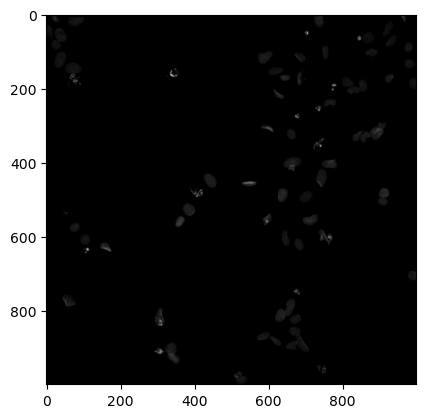

In [25]:
import os
import requests
from io import BytesIO
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import boto3

image_url = os.path.join(
    sample_linked.iloc[0].PathName_OrigDNA, sample_linked.iloc[0].FileName_OrigDNA
)
print(' Image url: ', image_url)
print(' Bucket   : ', image_url.split("/")[2])
print(' Key      : ', image_url.split("/")[3:])
s3_client = boto3.client("s3")
response = s3_client.get_object(
    Bucket=image_url.split("/")[2], Key="/".join(image_url.split("/")[3:])
)
image = mpimg.imread(BytesIO(response["Body"].read()), format="tiff")

plt.imshow(image, cmap="gray")
image_url


There's a lot more to come! We will add more example notebooks as we go.